Baseball Project

The baseball project aims to predict team playoffs. For more information, please refer to the Readme.md file.
 
We will first start by loading the data and then parsing it
All the raw data is stored under the "data" folder
The raw data consist of the following main files:
  MASTER - Player names, DOB, and biographical info
  Batting - batting statistics
  Pitching - pitching statistics
  Fielding - fielding statistics

And it is supplemented by these files:

  AllStarFull - All-Star appearances
  HallofFame - Hall of Fame voting data
  Managers - managerial statistics
  Teams - yearly stats and standings 
  BattingPost - post-season batting statistics
  PitchingPost - post-season pitching statistics
  TeamFranchises - franchise information
  FieldingOF - outfield position data  
  FieldingPost- post-season fieldinf data
  ManagersHalf - split season data for managers
  TeamsHalf - split season data for teams
  Salaries - player salary data
  SeriesPost - post-season series information
  AwardsManagers - awards won by managers 
  AwardsPlayers - awards won by players
  AwardsShareManagers - award voting for manager awards
  AwardsSharePlayers - award voting for player awards
  Appearances - details on the positions a player appeared at
  Schools - list of colleges that players attended
  CollegePlaying - list of players and the colleges they attended
  
  For the purspose of this project, we will be using only the "Teams' file. Should we need additional information later on, we might seek to load other files 


In [107]:
#Import all the libraries that we will use for this project
import os.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
%matplotlib inline
import seaborn as sns

In [131]:
DATA_DIR = os.path.join("..", "data", "core")
DATA_DIR = os.path.abspath(DATA_DIR)
#load the data
teams_data = pd.read_csv(os.path.join(DATA_DIR, "Teams.csv"),na_values="0",)

teams_data.head()

,yearID,lgID,teamID,name,franchID,divID,Rank,G,Ghome,W,...,E,DP,FP,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,Boston Red Stockings,BNA,NaN,3,31,NaN,20.0,...,225,NaN,0.838,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,Chicago White Stockings,CNA,NaN,2,28,NaN,19.0,...,218,NaN,0.829,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,Cleveland Forest Citys,CFC,NaN,8,29,NaN,10.0,...,223,NaN,0.814,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,Fort Wayne Kekiongas,KEK,NaN,7,19,NaN,7.0,...,163,NaN,0.803,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,New York Mutuals,NNA,NaN,5,33,NaN,16.0,...,227,NaN,0.839,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


The teams file consists of the following fields. So, let's review the descrition of each field and select what we keep and what we drop. Also, let's make sure that our data is clean and ready to be used.
yearID         Year -- keep
lgID           League -- keep
teamID         Team -- keep
franchID       Franchise (links to TeamsFranchise table)
divID          Team's division 
Rank           Position in final standings -- keep
G              Games played -- keep
GHome          Games played at home 
W              Wins -- keep
L              Losses  -- keep
DivWin         Division Winner (Y or N)-- keep
WCWin          Wild Card Winner (Y or N)-- keep
LgWin          League Champion(Y or N) -- keep
WSWin          World Series Winner (Y or N) -- keep
R              Runs scored -- keept
AB             At bats
H              Hits by batters
2B             Doubles
3B             Triples
HR             Homeruns by batters  ---keept
BB             Walks by batters
SO             Strikeouts by batters
SB             Stolen bases
CS             Caught stealing
HBP            Batters hit by pitch
SF             Sacrifice flies
RA             Opponents runs scored --keep
ER             Earned runs allowed
ERA            Earned run average -- keep
CG             Complete games
SHO            Shutouts
SV             Saves
IPOuts         Outs Pitched (innings pitched x 3)
HA             Hits allowed
HRA            Homeruns allowed
BBA            Walks allowed
SOA            Strikeouts by pitchers
E              Errors
DP             Double Plays
FP             Fielding  percentage
name           Team's full name -- keep
park           Name of team's home ballpark
attendance     Home attendance total
BPF            Three-year park factor for batters
PPF            Three-year park factor for pitchers
teamIDBR       Team ID used by Baseball Reference website
teamIDlahman45 Team ID used in Lahman database version 4.5
teamIDretro    Team ID used by Retrosheet


In [132]:
#drop all unnecessary columns
teams_data.drop(teams_data.columns[[1,3,4,5,8,16,17,18,19,21,22,23,24,25,26,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]], axis=1, inplace=True)
teams_data.head()



,yearID,teamID,Rank,G,W,L,DivWin,WCWin,LgWin,WSWin,R,HR,RA,ERA
0,1871,BS1,3,31,20.0,10,NaN,NaN,N,NaN,401,3.0,303,3.55
1,1871,CH1,2,28,19.0,9,NaN,NaN,N,NaN,302,10.0,241,2.76
2,1871,CL1,8,29,10.0,19,NaN,NaN,N,NaN,249,7.0,341,4.11
3,1871,FW1,7,19,7.0,12,NaN,NaN,N,NaN,137,2.0,243,5.17
4,1871,NY2,5,33,16.0,17,NaN,NaN,N,NaN,302,1.0,313,3.72


In [133]:
#drop all the lines where WSWin is null. This means that this data will not be useful in our model. It tooks like the World Series
#winners are provided until 1995
teams_data=teams_data.drop(teams_data[teams_data.yearID<1995].index)


In [161]:
#replace all NA values with zero
teams_data_clean = teams_data.fillna(0)
#replace Y and N with 0 and 1
teams_data_clean.replace(('Y', 'N',''), (1, 0,0), inplace=True)
#Convert W to integers
teams_data_clean.W=teams_data_clean.W.astype(int)
teams_data_clean.R=teams_data_clean.R.astype(int)
teams_data_clean.HR=teams_data_clean.HR.astype(int)
teams_data_clean.RA=teams_data_clean.RA.astype(int)
teams_data_clean.ERA=teams_data_clean.ERA.astype(float)


In [162]:
teams_data_clean.head()

,yearID,teamID,Rank,G,W,L,DivWin,WCWin,LgWin,WSWin,R,HR,RA,ERA
2181,1995,ATL,1,144,90,54,1,0,1,1,645,168,540,3.44
2182,1995,BAL,3,144,71,73,0,0,0,0,704,173,640,4.31
2183,1995,BOS,1,144,86,58,1,0,0,0,791,175,698,4.39
2184,1995,CAL,2,145,78,67,0,0,0,0,801,186,697,4.52
2185,1995,CHA,3,145,68,76,0,0,0,0,755,146,758,4.85


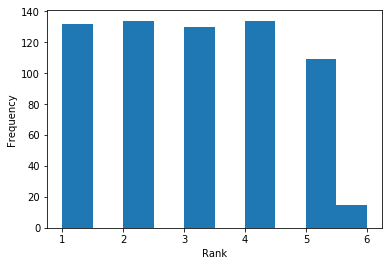

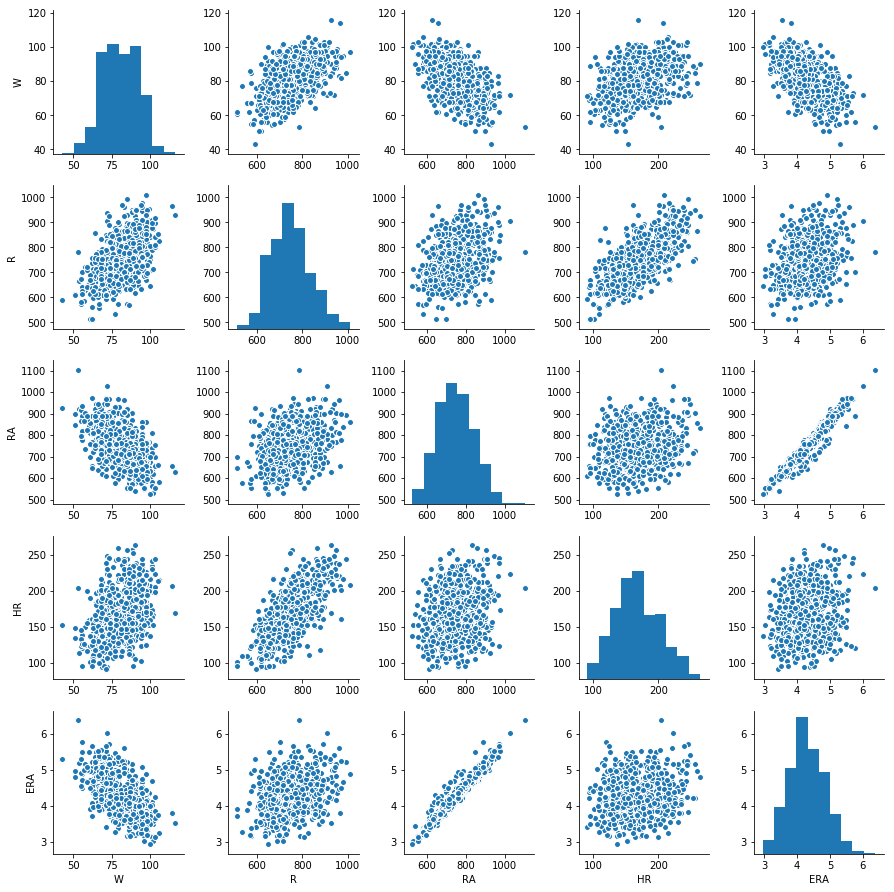

In [188]:
#Define the features and explore them
teams_features = ["W","R","RA","HR","ERA","LgWin"]

#vsualize the data to see any outliers or inconsistencies
sns.pairplot(teams_data[teams_features])

In [195]:
# define X and y
X_team = teams_data_clean[teams_features]
y_team = teams_data_clean.WSWin
# scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score



In [196]:
X_team_train, X_team_test, y_team_train, y_team_test = train_test_split(
    X_team, y_team, test_size=.2, random_state=1234
)

In [191]:
st_scaler_team = StandardScaler() 
min_scaler_team = MinMaxScaler()

st_scaler_team.fit(X_team_train)
min_scaler_team.fit(X_team_train)

X_st_train = st_scaler_team.transform(X_team_train)
X_st_test = st_scaler_team.transform(X_team_test)

X_m_train = min_scaler_team.transform(X_team_train)
X_m_test = min_scaler_team.transform(X_team_test)

kn_st = KNeighborsClassifier(n_neighbors=3)
kn_st.fit(X_st_train, y_team_train)
preds_st = kn_st.predict(X_st_test)

kn_m = KNeighborsClassifier(n_neighbors=3)
kn_m.fit(X_m_train, y_team_train)
preds_m = kn_st.predict(X_m_test)


In [192]:
metrics.accuracy_score(y_team_test, preds_st)

0.95419847328244278

In [193]:
metrics.accuracy_score(y_team_test, preds_m)

0.96183206106870234

Both scalers performed very bad. However, the issue is not the scaler, it is the model applied. We will in the next section to apply different models in order to get a better accuracy score.

In [197]:
# Use a decision tree model this time -- without scaling
decision_tree = DecisionTreeRegressor(max_depth=2)
decision_tree.fit(X_team_train, y_team_train)
print("Decision Tree RMSE for standard scaler:",
      np.sqrt(mean_squared_error(y_team_test, decision_tree.predict(X_team_test))))


('Decision Tree RMSE for standard scaler:', 0.12193659276358428)
